In [1]:
from extract import SocialETL, construct_query_for_twarc, extract_tags, SocialDB, UserETL
import hashtags as h
import hashtags_readcsv as r_csv
import pandas as pd
import numpy as np
import json
import statistics
import networkx as nx

# 1) Download DF

In [2]:
#modifiche: cambiare data e togliere lang eng
m = SocialETL(query="(#eurovision OR #covid OR #pridemonth OR #grammys OR #justiceforjohnnydepp OR #putin OR #russia OR #ukraine OR #war)", pages=1, recent=False) #strangerthings4 

Output()

In [3]:
user_id=m.df['author_id'] 
set_user=set(user_id)
#un utente può aver fatto più di un tweet, in questo modo andiamo a vedere i suoi ultimi tweet solo una volta.
print(len(set_user))

88


In [4]:
#estarre pure retweeted_user_id per edge
hashtag_for_user={}
tweet_for_user={}
retweet_for_user={}
verified_for_user={}
location_for_user={}

for e in set_user:                                                             #1 pages=20 tweet   
    u=UserETL(e,pages=1)                                                       #aggiungere più pagine (1pag=20)
    #preprocessing hashtag
    u.df=u.df.dropna(subset=['entities.hashtags'])                             #drop nan values on column hashtags
    u.df.reset_index()
    u.df['entities.hashtags']=u.df['entities.hashtags'].apply(eval)            #convert into dict
    u.df["entities.hashtags"] = u.df["entities.hashtags"].map(h.extract_tags)  #extract tags
    hashtag_for_user[e]=u.df["entities.hashtags"].tolist()                     #convert pandas series into a list
    #preprocessing retweet
    u.df=u.df.dropna(subset=['retweeted_user_id'])
    retweet_for_user[e]=u.df['retweeted_user_id'].tolist()
    tweet_for_user[e]=u.df['id'].tolist() 
    location_for_user[e]=u.df['author.location'].tolist()
    verified_for_user[e]=u.df['author.verified']

Output()

Output()

caught requests exception: HTTPSConnectionPool(host='api.twitter.com', port=443): Read timed out. (read timeout=3.05)
caught requests exception: HTTPSConnectionPool(host='api.twitter.com', port=443): Read timed out. (read timeout=3.05)


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [7]:
user_id=[]
tweet_id=[]
hashtag=[]
retweet=[]
location=[]
verified=[]
for u,h in hashtag_for_user.items():
    user_id.append(u)
    hashtag.append(h)
for u,t in tweet_for_user.items():
    tweet_id.append(t)
for u,r in retweet_for_user.items():
    retweet.append(r)
for u,l in location_for_user.items():
    location.append(l)
for u,v in verified_for_user.items():
    verified.append(v)

In [8]:
print(len(location))

88


In [29]:
loc=[]
for lists in location:
    nest_loc=[]
    for el in lists:  
        if isinstance(el,float):
            nest_loc.append(0) #remove nan locations
        elif isinstance(el,str):
            nest_loc.append(statistics.mode(lists)) #set as locaton the most used one
    loc.append(nest_loc)

In [30]:
#create a pandas dataframe
df_nodes=pd.DataFrame({"user_id":user_id,
                       'tweet_id':tweet_id,
                      'retweet_id': retweet,
                      "hashtag":hashtag,
                     'location':loc,
                     'verified':verified})
df_nodes

,user_id,tweet_id,retweet_id,hashtag,location,verified
0,2312497335,"[1556655988874289153, 1555938148315717632]","[1502349083981324288, 1502349083981324288]","[[ukrainianarmy, ukraine], [actforukraine, ukr...","[København, Danmark, København, Danmark]","0 False 7 False Name: author.verified, d..."
1,1496859992116375557,"[1556650152529727494, 1556625020729843715]","[758319705849524224, 758319705849524224]","[[russia, donbass, demilitarization, denazific...","[0, 0]","2 False 7 False Name: author.verified, d..."
2,200620727,"[1556655873090543616, 1556655798251655171, 155...","[819657303788056576, 87358629, 151887925290880...","[[childprotectionregister, shielding, evusheld...","[ Cornwall UK, Cornwall UK, Cornwall UK, Co...",2 False 3 False 4 False 5 Fals...
3,1521989274190872576,[],[],"[[zelensky, ukraine]]",[],"Series([], Name: author.verified, dtype: bool)"
4,1442161841912700929,[],[],"[[avanti, river], [money, ukraine], [river, et...",[],"Series([], Name: author.verified, dtype: bool)"
...,...,...,...,...,...,...
83,226434373,"[1556656003311013888, 1556654766268116994, 155...","[1495480590572961792, 95440329, 82445570890945...","[[ukraine], [voteyouout2022], [deathsantis]]","[0, 0, 0]",0 False 3 False 18 False Name: auth...
84,303426991,"[1556656301387776003, 1556655797530247170, 155...","[1320680668221919235, 943906396180905984, 7320...","[[mariupol, azovstaldefenders], [ukraine], [wi...","[Prague, Czech Republic, Prague, Czech Republi...",0 False 1 False 11 False 12 Fals...
85,434354062,[],[],"[[otan], [putin], [donbass, putin]]",[],"Series([], Name: author.verified, dtype: bool)"
86,1274377712405266432,"[1556655961644974080, 1556630736597356546, 155...","[859407061230252032, 754718787237281792, 12856...","[[paris, ukraine, russie], [taiwan], [], [paris]]","[Belgique, Belgique, Belgique, Belgique]",3 False 14 False 15 False 17 Fals...


In [31]:
def user_set(u):
    user=set()
    user.add(u)
    return user
user=df_nodes['user_id'] #save for nodes
df_nodes['user_id']=df_nodes['user_id'].map(int)
df_nodes['user_id']=df_nodes['user_id'].map(user_set) #users into a set

In [32]:
#df_nodes.to_csv('4438_users_csv')
#df_nodes=pd.read_csv('4438_users_csv')

In [33]:
#convert nested lists on set
def to_sets(nested_lists): 
    outer_list = set()
    for el in nested_lists: 
        if type(el) == list: 
            outer_list.update(el) 
        else: 
            outer_list.add(el)
    return outer_list
#nested_list=[['onepiece', 'onepiecefilmred'], ['dbacks']]

In [34]:
df_nodes['hashtag']=df_nodes['hashtag'].map(to_sets)
df_nodes['tweet_id']=df_nodes['tweet_id'].map(to_sets)
df_nodes['retweet_id']=df_nodes['retweet_id'].map(to_sets)
df_nodes['verified']=df_nodes['verified'].map(to_sets)
df_nodes['location']=df_nodes['location'].map(to_sets)

In [35]:
df_nodes

,user_id,tweet_id,retweet_id,hashtag,location,verified
0,{2312497335},"{1555938148315717632, 1556655988874289153}",{1502349083981324288},"{ukrainewillwin, ukraine, actforukraine, ukrai...","{København, Danmark}",{False}
1,{1496859992116375557},"{1556625020729843715, 1556650152529727494}",{758319705849524224},"{ukropropaganda, lnr, ukrainian, dnr, wetogeth...",{0},{False}
2,{200620727},"{1556648803486285827, 1556655798251655171, 155...","{918956395541794816, 354341115, 115389797, 873...","{longcovid, antibodies, evusheld, immunocompro...",{ Cornwall UK},{False}
3,{1521989274190872576},{},{},"{ukraine, zelensky}",{},{}
4,{1442161841912700929},{},{},"{money, monthly, republicans, ministra, ethere...",{},{}
...,...,...,...,...,...,...
83,{226434373},"{1556645753048551424, 1556656003311013888, 155...","{824455708909457409, 1495480590572961792, 9544...","{voteyouout2022, ukraine, deathsantis}",{0},{False}
84,{303426991},"{1556650169055252482, 1556650090395303936, 155...","{943906396180905984, 73206956, 132068066822191...","{european, mariupol, azovstaldefenders, winter...","{Prague, Czech Republic}",{False}
85,{434354062},{},{},"{donbass, putin, otan}",{},{}
86,{1274377712405266432},"{1556630718352171009, 1556630736597356546, 155...","{1285618608299745281, 754718787237281792, 1214...","{, paris, taiwan, russie, ukraine}",{Belgique},{False}


In [16]:
#df_nodes.to_csv('set_4438_users_csv')
#df_nodes=pd.read_csv('set_4438_users_csv')

# 2) Categorizzazione utenti

In [17]:
with open('hashtags_300.json', 'r') as f:
    my_dict = json.load(f)

In [18]:
proukr=set()
prorus=set()
pax=set()
for k,v in my_dict.items():
    for e in v:
        if k=='proukr':
            proukr.update(e)
        elif k=='pax':
            pax.update(e)
        elif k=='prorus':
            prorus.update(e)

In [19]:
cat=set.union(proukr,prorus,pax)
count1=0
count4=0
index1=[]
index4=[]

for i, row in enumerate(df_nodes['hashtag']): 
    if row.intersection(cat)==set():#no intersezione   
        #print(row.intersectionn(cat))
        #print("l'utente {}  appartiene alla 4 categoria".format(row.intersection(cat)))
        #print("4 categoria", row)
        count4 += 1
        index4.append(i)
        
    else: #c'è intersezione: uno della 3 categorie
        #print("non è la 4 categoria perchè contiene",row.intersection(cat))
       # if row.intersection(proukr)!=set(): #c'è intersez con proukr
            count1 += 1
            index1.append(i) #aggiungo alle rige da tgliere
            print("l'utente {} non  appartiene alla 4 categoria perchè usa {}".format(df_nodes['user_id'].loc[i],row.intersection(cat)))

l'utente {2312497335} non  appartiene alla 4 categoria perchè usa {'ukrainewillwin', 'ukrainianarmy', 'actforukraine', 'ukraine'}
l'utente {1496859992116375557} non  appartiene alla 4 categoria perchè usa {'ucraina', 'donbas', 'donbass', 'donetsk', 'france', 'armedforcesofukraine', 'russians', 'russian', 'kherson', 'ukrainian', 'lugansk', 'selenskyj', 'zaporizhzhia', 'zelenskywarcriminal', 'zelenskiy', 'russia', 'ukraine'}
l'utente {200620727} non  appartiene alla 4 categoria perchè usa {'covid'}
l'utente {1521989274190872576} non  appartiene alla 4 categoria perchè usa {'ukraine', 'zelensky'}
l'utente {1442161841912700929} non  appartiene alla 4 categoria perchè usa {'covid19', 'taiwan', 'chicago', 'ethereum', 'ukraine'}
l'utente {3364490722} non  appartiene alla 4 categoria perchè usa {'ukrainerussiawar', 'putin', 'karma', 'russia'}
l'utente {1206693704657862656} non  appartiene alla 4 categoria perchè usa {'israel', 'donetsk', 'ukraine'}
l'utente {1416813017476513801} non  appartien

l'utente {65970675} non  appartiene alla 4 categoria perchè usa {'covid', 'wearamask', 'monkeypox'}
l'utente {1304158776434491392} non  appartiene alla 4 categoria perchè usa {'breaking', 'joebiden', 'france', 'moscow', 'israel', 'un', 'muslim', 'breakingnews', 'zaporizhzhia', 'europe', 'russia', 'ukraine'}
l'utente {1114810989604741120} non  appartiene alla 4 categoria perchè usa {'orban', 'france', 'energy', 'lgbtq', 'serbia', 'hungary', 'grain', 'germany', 'war', 'sanctions', 'gas', 'canada', 'europe', 'russia', 'ukraine', 'kosovo', 'nazi'}
l'utente {1445514941427896326} non  appartiene alla 4 categoria perchè usa {'kyiv', 'stopputin', 'ukrainian', 'ukrainekrieg', 'canada', 'kherson', 'russia', 'ukraine', 'ukrainerussiawar', 'donbass', 'russian', 'himars', 'russiaisaterroriststate', 'ukrainewar', 'odesa', 'uk', 'usa', 'finland', 'nato'}
l'utente {797757316493938688} non  appartiene alla 4 categoria perchè usa {'poutine', 'covid'}
l'utente {1505544235420119041} non  appartiene alla 4

In [20]:
print('nocare = {} \n'
      'altre categorie = {}'.format(count4, count1))

nocare = 3 
altre categorie = 85


In [23]:
df_nodes['cat']=False
for i in index4:
    df_nodes['cat'].loc[i]='nocare'

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [88]:
#parte categorizzazione tweet e utenti di proukr, prorus, pax
copia lavoro fabio

SyntaxError: invalid syntax (2154813119.py, line 2)

# 3 Creazione rete

In [21]:
G = nx.Graph()

In [24]:
#assegnazione propietà al nodo, ex: categoria, 'author.location', 'author.verified', 
for i, e in enumerate(user):
    G.add_node(e, cat=df_nodes['cat'][i], loc=df_nodes['location'][i], verfied=df_nodes['verified'][i]) #->aggiungere cat a ogni nodo
list(G.nodes.data()) #stampa proprietà di ogni nodo come dict()

[('2312497335',
  {'cat': False, 'loc': {'København, Danmark'}, 'verfied': {False}}),
 ('1496859992116375557', {'cat': False, 'loc': {0}, 'verfied': {False}}),
 ('200620727', {'cat': False, 'loc': {' Cornwall UK'}, 'verfied': {False}}),
 ('1521989274190872576', {'cat': False, 'loc': set(), 'verfied': set()}),
 ('1442161841912700929', {'cat': False, 'loc': set(), 'verfied': set()}),
 ('3364490722', {'cat': False, 'loc': {0}, 'verfied': {False}}),
 ('1206693704657862656',
  {'cat': False, 'loc': {'Retardistan, Russophilistan'}, 'verfied': {False}}),
 ('1416813017476513801',
  {'cat': False, 'loc': {'Aix-en-Provence, France'}, 'verfied': {False}}),
 ('1440562358028406790', {'cat': False, 'loc': {0}, 'verfied': {False}}),
 ('36961157', {'cat': 'nocare', 'loc': set(), 'verfied': set()}),
 ('29510241',
  {'cat': False, 'loc': {'Planète Terre et Mars'}, 'verfied': {False}}),
 ('1081472098546135040', {'cat': False, 'loc': {0}, 'verfied': {False}}),
 ('68229976', {'cat': False, 'loc': {0}, 'ver

In [25]:
#crea edges tra nodi
edges=[]
user_set=set()
for e in df_nodes['user_id']:
    user_set.update(e)
for id_retweet in df_nodes['retweet_id']:
    if id_retweet.intersection(user_set)!=set():
        print('ok')
        edges.append([id_retweet,id_retweet.intersection(user_set)])
edges

[]

In [28]:
#assegnazione link ai nodi
from_node=[]
to_node=[]
for n1,n2 in edges:
    from_node.append(n1)
    to_node.append(n2)
i=0
while i<len(edges):
    G.add_edge(from_node[i],to_node[i])
    i +=1

In [93]:
G.number_of_edges()

0

In [94]:
G.number_of_nodes()

87

In [ ]:
G.remove_nodes_from(list(nx.isolates(G)))

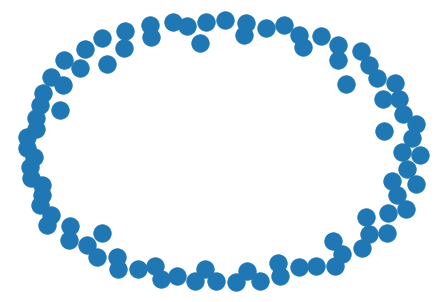

In [95]:
nx.draw(G)